In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from train import generate_training_examples
from model_l2 import DeconvolutionModel

import sys

def main():
    # Use hardware accelerator if available
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using {device} device")

    # TODO: Change so dataframe passed directly
    # This way we can subset it in this script for faster training during development
    n = 10000
    known_freqs_file = f'known_freqs_{n}.npy'
    snv_freqs_file = f'snv_freqs_{n}.npy'

    # If training data exists just read from file
    # TODO: Can add a --force argument later
    if os.path.exists(known_freqs_file) and os.path.exists(snv_freqs_file):
        # Load data from files
        known_freqs = torch.tensor(np.load(known_freqs_file), dtype=torch.float32)
        snv_freqs = torch.tensor(np.load(snv_freqs_file), dtype=torch.float32)
    else:
        # Generate training examples if files do not exist
        known_freqs, snv_freqs = generate_training_examples('data/usher_barcodes.csv', n)
        
        # Save generated data to files
        np.save(known_freqs_file, known_freqs.numpy())
        np.save(snv_freqs_file, snv_freqs.numpy())

    # Move tensors to the selected device
    known_freqs = known_freqs.to(device)
    snv_freqs = snv_freqs.to(device)
    dataset = TensorDataset(snv_freqs, known_freqs)  # x,y

    # Example: Print the shapes of the tensors
    print(f"Shape of known_freqs tensor: {known_freqs.shape}")
    print(f"Shape of snv_freqs tensor: {snv_freqs.shape}")

    # TODO: CLI arguments to set the split
    total_size = len(dataset)
    test_size = total_size // 10  # 10% for test
    validation_size = total_size // 10  # 10% for validation
    train_size = total_size - test_size - validation_size  # 80% train

    # Split the dataset
    train_dataset, validation_dataset, test_dataset = random_split(
        dataset, [train_size, validation_size, test_size]
    )

    # verify sizes
    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(validation_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    # DataLoaders (makes training in batches easier)
    batch_size = 1000  # Arbitrarily chosen
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print first batch for validation
    for batch in train_loader:
        snv_freqs_batch, known_freqs_batch = batch
        print(f"Known frequencies batch shape: {known_freqs_batch.shape}")
        print(f"SNV frequencies batch shape: {snv_freqs_batch.shape}")
        print(f"First batch - SNV frequencies: {snv_freqs_batch}")
        print(f"First batch - Known frequencies: {known_freqs_batch}")
        for i, freq in enumerate(known_freqs_batch):
            non_zero_freq = freq[freq != 0]
            print(f"First batch - Known frequencies (non-zero) {i}: {non_zero_freq}\n")
            break
        print()
        break

    # Print the first batch of the validation_loader
    for batch in validation_loader:
        snv_freqs_batch, known_freqs_batch = batch
        print(f"Validation Known frequencies batch shape: {known_freqs_batch.shape}")
        print(f"Validation SNV frequencies batch shape: {snv_freqs_batch.shape}")
        print(f"Validation batch - SNV frequencies: {snv_freqs_batch}")
        print(f"Validation batch - Known frequencies: {known_freqs_batch}")
        for i, freq in enumerate(known_freqs_batch):
            non_zero_freq = freq[freq != 0]
            print(f"Validation batch - Known frequencies (non-zero) {i}: {non_zero_freq}\n")
            break
        print()
        break

    # Print the first batch of the test_loader
    for batch in test_loader:
        snv_freqs_batch, known_freqs_batch = batch
        print(f"Test Known frequencies batch shape: {known_freqs_batch.shape}")
        print(f"Test SNV frequencies batch shape: {snv_freqs_batch.shape}")
        print(f"Test batch - SNV frequencies: {snv_freqs_batch}")
        print(f"Test batch - Known frequencies: {known_freqs_batch}")
        for i, freq in enumerate(known_freqs_batch):
            non_zero_freq = freq[freq != 0]
            print(f"Test batch - Known frequencies (non-zero) {i}: {non_zero_freq}")
            break
        print()
        break
    
    # Initialize the model (example input and output sizes)
    input_size = snv_freqs.shape[1]
    output_size = known_freqs.shape[1]
    num_hidden_layers = 1  # simplest model

    model = DeconvolutionModel(input_size, output_size, num_hidden_layers, device)

    # Train the model
    model.fit(train_loader, validation_loader, epochs=500)

    # Evaluate the model
    model.evaluate(validation_loader)

    # Predict using the model
    predictions, actuals = model.predict(test_loader)

    print(predictions)
    print(actuals)

    plt.figure(figsize=(10, 6))
    plt.plot(model.train_losses, label='Training Loss')
    plt.plot(model.val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Epochs')
    plt.show()

    # Plot predicted vs observed frequencies as a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions.flatten(), actuals.flatten(), alpha=0.5)
    plt.xlabel('Predicted Frequencies')
    plt.ylabel('Actual Frequencies')
    plt.title('Predicted vs Actual Frequencies')
    plt.show()

if __name__ == "__main__":
    main()

Using mps device
Shape of known_freqs tensor: torch.Size([10000, 3937])
Shape of snv_freqs tensor: torch.Size([10000, 6520])
Training set size: 8000
Validation set size: 1000
Test set size: 1000
Known frequencies batch shape: torch.Size([1000, 3937])
SNV frequencies batch shape: torch.Size([1000, 6520])
First batch - SNV frequencies: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1766, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2697, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1930, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.3567, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0302, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2432, 0.0000]],
       device='mps:0')
First batch - Known frequencies: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.

KeyboardInterrupt: 

Using mps device
Shape of known_freqs tensor: torch.Size([10000, 3937])
Shape of snv_freqs tensor: torch.Size([10000, 6520])
Training set size: 8000
Validation set size: 1000
Test set size: 1000
Known frequencies batch shape: torch.Size([1000, 3937])
SNV frequencies batch shape: torch.Size([1000, 6520])
First batch - SNV frequencies: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1952, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1161, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4511, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0112,  ..., 0.0000, 0.3508, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0242, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2485, 0.0000]],
       device='mps:0')
First batch - Known frequencies: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.

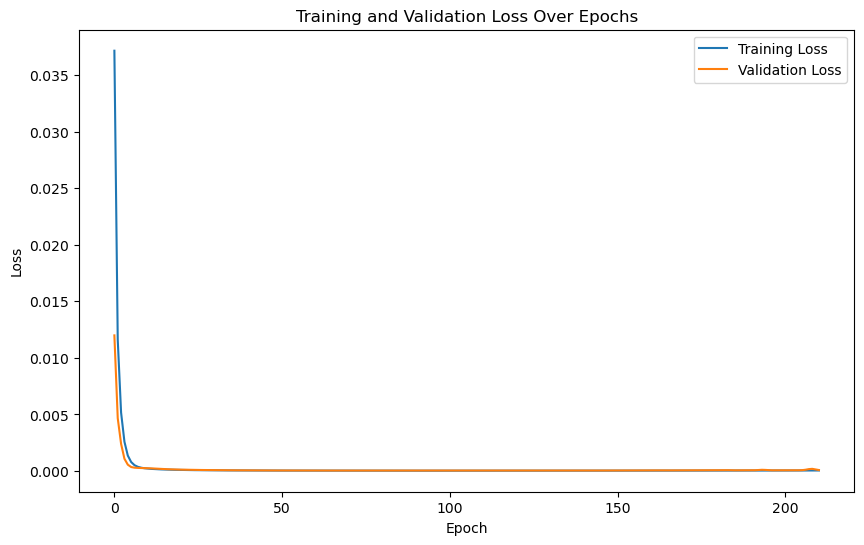

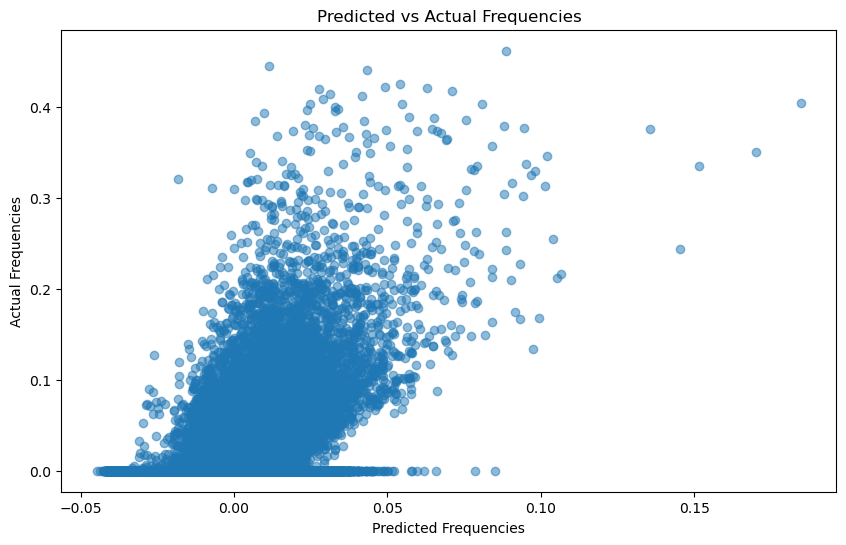

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from train import generate_training_examples
from model_l2 import DeconvolutionModel

import sys

def main():
    # Use hardware accelerator if available
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using {device} device")

    # TODO: Change so dataframe passed directly
    # This way we can subset it in this script for faster training during development
    n = 10000
    known_freqs_file = f'known_freqs_{n}.npy'
    snv_freqs_file = f'snv_freqs_{n}.npy'

    # If training data exists just read from file
    # TODO: Can add a --force argument later
    if os.path.exists(known_freqs_file) and os.path.exists(snv_freqs_file):
        # Load data from files
        known_freqs = torch.tensor(np.load(known_freqs_file), dtype=torch.float32)
        snv_freqs = torch.tensor(np.load(snv_freqs_file), dtype=torch.float32)
    else:
        # Generate training examples if files do not exist
        known_freqs, snv_freqs = generate_training_examples('data/usher_barcodes.csv', n)
        
        # Save generated data to files
        np.save(known_freqs_file, known_freqs.numpy())
        np.save(snv_freqs_file, snv_freqs.numpy())

    # Move tensors to the selected device
    known_freqs = known_freqs.to(device)
    snv_freqs = snv_freqs.to(device)
    dataset = TensorDataset(snv_freqs, known_freqs)  # x,y

    # Example: Print the shapes of the tensors
    print(f"Shape of known_freqs tensor: {known_freqs.shape}")
    print(f"Shape of snv_freqs tensor: {snv_freqs.shape}")

    # TODO: CLI arguments to set the split
    total_size = len(dataset)
    test_size = total_size // 10  # 10% for test
    validation_size = total_size // 10  # 10% for validation
    train_size = total_size - test_size - validation_size  # 80% train

    # Split the dataset
    train_dataset, validation_dataset, test_dataset = random_split(
        dataset, [train_size, validation_size, test_size]
    )

    # verify sizes
    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(validation_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    # DataLoaders (makes training in batches easier)
    batch_size = 1000  # Arbitrarily chosen
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print first batch for validation
    for batch in train_loader:
        snv_freqs_batch, known_freqs_batch = batch
        print(f"Known frequencies batch shape: {known_freqs_batch.shape}")
        print(f"SNV frequencies batch shape: {snv_freqs_batch.shape}")
        print(f"First batch - SNV frequencies: {snv_freqs_batch}")
        print(f"First batch - Known frequencies: {known_freqs_batch}")
        for i, freq in enumerate(known_freqs_batch):
            non_zero_freq = freq[freq != 0]
            print(f"First batch - Known frequencies (non-zero) {i}: {non_zero_freq}\n")
            break
        print()
        break

    # Print the first batch of the validation_loader
    for batch in validation_loader:
        snv_freqs_batch, known_freqs_batch = batch
        print(f"Validation Known frequencies batch shape: {known_freqs_batch.shape}")
        print(f"Validation SNV frequencies batch shape: {snv_freqs_batch.shape}")
        print(f"Validation batch - SNV frequencies: {snv_freqs_batch}")
        print(f"Validation batch - Known frequencies: {known_freqs_batch}")
        for i, freq in enumerate(known_freqs_batch):
            non_zero_freq = freq[freq != 0]
            print(f"Validation batch - Known frequencies (non-zero) {i}: {non_zero_freq}\n")
            break
        print()
        break

    # Print the first batch of the test_loader
    for batch in test_loader:
        snv_freqs_batch, known_freqs_batch = batch
        print(f"Test Known frequencies batch shape: {known_freqs_batch.shape}")
        print(f"Test SNV frequencies batch shape: {snv_freqs_batch.shape}")
        print(f"Test batch - SNV frequencies: {snv_freqs_batch}")
        print(f"Test batch - Known frequencies: {known_freqs_batch}")
        for i, freq in enumerate(known_freqs_batch):
            non_zero_freq = freq[freq != 0]
            print(f"Test batch - Known frequencies (non-zero) {i}: {non_zero_freq}")
            break
        print()
        break
    
    # Initialize the model (example input and output sizes)
    input_size = snv_freqs.shape[1]
    output_size = known_freqs.shape[1]
    num_hidden_layers = 1  # simplest model

    model = DeconvolutionModel(input_size, output_size, num_hidden_layers, device)

    # Train the model
    model.fit(train_loader, validation_loader, epochs=500)

    # Evaluate the model
    model.evaluate(validation_loader)

    # Predict using the model
    predictions, actuals = model.predict(test_loader)

    print(predictions)
    print(actuals)

    plt.figure(figsize=(10, 6))
    plt.plot(model.train_losses, label='Training Loss')
    plt.plot(model.val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Epochs')
    plt.show()

    # Plot predicted vs observed frequencies as a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions.flatten(), actuals.flatten(), alpha=0.5)
    plt.xlabel('Predicted Frequencies')
    plt.ylabel('Actual Frequencies')
    plt.title('Predicted vs Actual Frequencies')
    plt.show()

if __name__ == "__main__":
    main()